## Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os, sys
import numpy as np
import csv
import cv2

In [3]:
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
pip install pandas

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/c3/6c/ea362eef61f05553aaf1a24b3e96b2d0603f5dc71a3bd35688a24ed88843/pandas-2.0.3-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/9c/3d/a121f284241f08268b21359bd425f7d4825cffc5ac5cd0e1b3d82ffd2b10/pytz-2024.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tzdata>=2022.1 from https://files.pythonhosted.org/packages/65/58/f9c9e6be752e9fcb8b6a0ee9fb87e6e7a1f6bcab2cdc73f02bb7ba91ada0/tzdata-2024.1-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.8 MB 262.6 kB/s eta 0:00:41
   ---------------------------------------- 0.0/10.8 MB 262.6 kB/s eta 0:00:41
   ---------

In [7]:
pip install jieba

     ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
     --------------------------------------- 0.0/19.2 MB 186.2 kB/s eta 0:01:44
     --------------------------------------- 0.0/19.2 MB 186.2 kB/s eta 0:01:44
     --------------------------------------- 0.0/19.2 MB 186.2 kB/s eta 0:01:44
     --------------------------------------- 0.0/19.2 MB 186.2 kB/s eta 0:01:44
     --------------------------------------- 0.0/19.2 MB 186.2 kB/s eta 0:01:44
     ---------------------------------------- 0.0/19.2 MB 98.1 kB/s eta 0:03:16
     --------------------------------------- 0.1/19.2 MB 136.5 kB/s eta 0:02:21
     --------------------------------------- 0.1/19.2 MB 140.3 kB/s eta 0:02:17
     --------------------------------------- 0.1/19.2 MB 174.7 kB/s eta 0:01:50
     --------------------------------------- 0.1/19.2 MB 198.4 k

In [8]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import numpy as np
from PIL import Image
import networkx as nx
from IPython.display import Image as iImage
from IPython.display import display
import math
import matplotlib.pyplot as plt
import ebooklib
from ebooklib import epub
import random
import re
import os
import nltk
from nltk.corpus import words
import gensim
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, stopwords, names
from sklearn.decomposition import PCA
import scipy.spatial
from matplotlib import cm
import matplotlib.image as mpimg
import pandas as pd
import jieba
from sklearn.metrics.pairwise import linear_kernel
from nltk import pos_tag
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import sklearn

In [11]:
!pip install pyenchant
!apt-get install libenchant-2-2

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


## Process Texts

In [16]:
from preprocessmodel import preprocessmodel

In [19]:
def merge_strings_until_limit(strings, min_length, max_length, test_for_max=0):
    merged_string = ""
    merged_strings = []

    for s in strings:
        if len(merged_string) <= min_length:
            merged_string += s
        elif len(merged_string) > max_length and test_for_max < 5:
            split_paragraph = merged_string.split('.')
            split_paragraph_repoint = []
            for sp in split_paragraph:
                split_paragraph_repoint.append(sp + '.')
            merged = merge_strings_until_limit(split_paragraph_repoint, min_length, max_length, test_for_max + 1)
            merged_strings.extend(merged)
            merged_string = s
        else:
            merged_strings.append(merged_string)
            merged_string = s

    if merged_string:
        merged_strings.append(merged_string)

    return merged_strings

In [20]:
import ebooklib
import re

def read_epub_book(epub_file, ID):
    book = ebooklib.epub.read_epub(epub_file)
    text = ""

    for item in book.get_items():
        if item.get_type() == ebooklib.ITEM_DOCUMENT:
            content = item.get_content().decode('utf-8')
            content = re.sub('<[^<]+?>', '', content)  # Remove HTML tags
            content = re.sub('\s+', ' ', content)  # Replace multiple whitespaces with a single space
            content = re.sub('\n', ' ', content)
            content = re.sub("&#13;", ' ', content)
            text += content
            #paragraphs.extend(content.strip().split("&#13;"))
    book_item = {'text': text, 'bookID':ID}
    return book_item

def read_epub_paragraphs(epub_file, ID):
    book = ebooklib.epub.read_epub(epub_file)
    paragraphs = []

    for item in book.get_items():
        if item.get_type() == ebooklib.ITEM_DOCUMENT:
            content = item.get_content().decode('utf-8')
            content = re.sub('<[^<]+?>', '', content)  # Remove HTML tags
            content = re.sub('\s+', ' ', content)  # Replace multiple whitespaces with a single space
            content = re.sub('\n', ' ', content)
            paragraphs.extend(content.strip().split("&#13;"))
    paragraphs = merge_strings_until_limit(paragraphs, 200, 1000)
    paragraphs = [{'paragraph':paragraphs[i], 'nr':i,'bookID':ID} for i in range(len(paragraphs)) if len(paragraphs[i])>50]
    return paragraphs[1:-1]

def process_multiple_epub_files(file_paths):
    all_paragraphs = []
    all_books = []
    for idx, file_path in enumerate(file_paths, start=1):
        paragraphs = read_epub_paragraphs(file_path, idx)
        all_paragraphs.extend(paragraphs)
        book_info = read_epub_book(file_path, idx)
        all_books.append(book_info)
    return all_books, all_paragraphs

file_paths = ['D:\\FinalAssignment\\Books\\huxley-brave-new-world.epub', 'D:\\FinalAssignment\\Books\\morris-news-from-nowhere.epub', 'D:\\FinalAssignment\\Books\\orwell-nineteen-eighty-four.epub']  # Add more file paths as needed
books, paragraphs = process_multiple_epub_files(file_paths)

In [22]:
list = []
list = books, paragraphs

In [27]:
data = list
with open('JSON/list.json', "w") as json_file:
    json.dump(data, json_file)

In [45]:
with open('JSON/list.json', 'r') as file:
    # Load the JSON data into a Python dictionary
    data01 = json.load(file)

In [56]:
data02 = data01[1]

In [63]:
data02[:3]

[{'paragraph': 'Brave New World Aldous Huxley Copyright © 2014 epubBooks All Rights Reserved. This publication is protected by copyright. By payment of the required fees, you have been granted the non-exclusive, non-transferable right to access and read the text of this ebook on-screen or via personal text-to-speech computer systems. No part of this text may be reproduced, transmitted, downloaded, decompiled, reverse engineered, stored in or introduced into any information storage and retrieval system, in any form or by any means, whether electronic or mechanical, now known or hereinafter invented, without the express written permission of epubBooks. www.epubbooks.com',
  'nr': 1,
  'bookID': 1},
 {'paragraph': "Chapter One A squat grey building of only thirty–four stories. Over the main entrance the words, CENTRAL LONDON HATCHERY AND CONDITIONING CENTRE, and, in a shield, the World State's motto, COMMUNITY, IDENTITY, STABILITY.",
  'nr': 2,
  'bookID': 1},
 {'paragraph': ' The enormou

In [64]:
paragraphs = [item['paragraph'] for item in data02]


In [66]:
paragraphs[2]

' The enormous room on the ground floor faced towards the north. Cold for all the summer beyond the panes, for all the tropical heat of the room itself, a harsh thin light glared through the windows, hungrily seeking some draped lay figure, some pallid shape of academic goose–flesh, but finding only the glass and nickel and bleakly shining porcelain of a laboratory.'

In [61]:
text_list

[]

In [117]:
from preprocessmodel import preprocess
processed_text=preprocess(paragraphs)
#preprocess_text_list = processed_text.preprocess_text_list

In [73]:
processed_text

['brave new world copyright right reserved publication copyright payment fee non exclusive non transferable right access read text screen via personal text speech computer system part text may reverse information storage retrieval system form mean whether electronic mechanical known hereinafter without express written permission',
 'chapter one squat grey building thirty four story main entrance word central hatchery shield world state motto community identity stability',
 'enormous room ground floor faced towards north cold summer beyond pane tropical heat room harsh thin light window hungrily seeking lay figure pallid shape academic goose flesh finding glass nickel bleakly shining porcelain laboratory',
 'wintriness wintriness overall worker white hand pale corpse rubber light wa frozen dead ghost yellow barrel microscope borrow certain rich living substance lying along polished tube like butter streak luscious streak long recession work table',
 'said director opening door room bent

## SOM for Texts

In [74]:
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU1(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'cosine')[0][0]
    QE = sumSqDist/len(data)
    return QE
def find_BMU_2(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argpartition(cos_sims, -2, axis=None)[-2], cos_sims.shape)
def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU1(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p
def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p
def find_BMU1(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argmax(cos_sims, axis=None), cos_sims.shape)

def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        np.random.shuffle(train_data)
        for train_ex in train_data:
            g, h = find_BMU1(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)
    return SOM
def cosine(a,b):
    return cosine_similarity([a], [b])[0][0]

def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)
    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += cosine(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += cosine(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values
def activate1(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[cosine_similarity([normalP], [c])[0][0] for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    #activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM
def normalise_2(train):
    min_d = np.min(train, axis=0)
    max_d = np.max(train, axis=0)
    normalised_train = (train - min_d) / (max_d - min_d)
    return normalised_train
def find_closest_cos(data, v):
    cos_dist = cosine_similarity(data, [v])
    return np.argmax(cos_dist)

In [75]:
sentences=processed_text
tagged_data = [TaggedDocument(words=sentence.split(), tags=[str(i)]) for i, sentence in enumerate(sentences)]
model1 = Doc2Vec(vector_size=300, min_count=1, epochs=10)
model1.build_vocab(tagged_data)
model1.train(tagged_data, total_examples=model1.corpus_count, epochs=model1.epochs)
sentence_vectors = [model1.infer_vector(sentence.split()) for sentence in sentences]
#u_matrix = np.array(sentence_vectors)

In [76]:
with open('sentence_vectors.pkl', 'wb') as f:
    pickle.dump(sentence_vectors, f)

Epoch: 1, QE: 0.0723, TE: 0.174


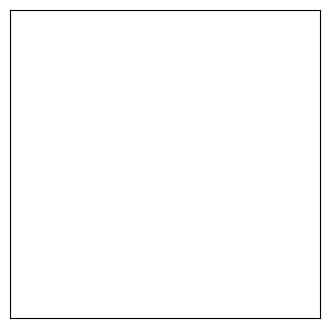

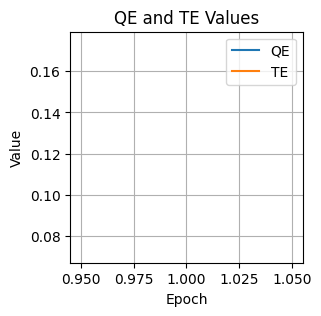

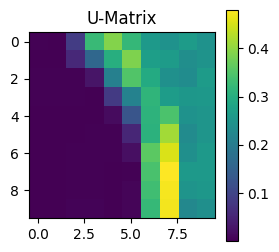

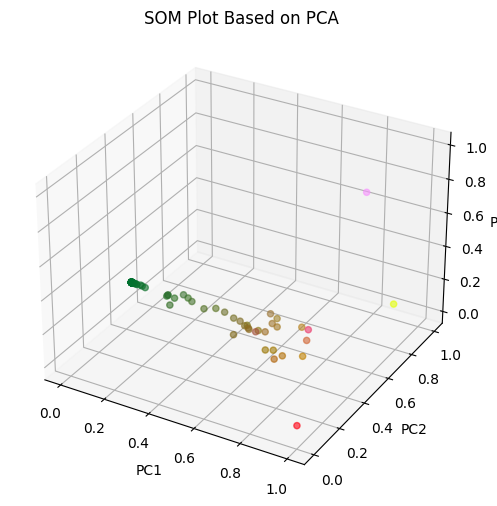

Epoch: 2, QE: 0.0731, TE: 0.162


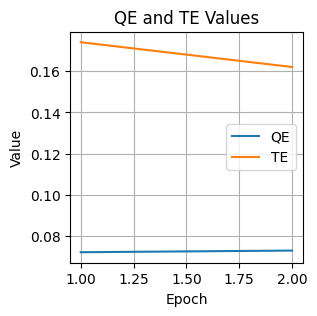

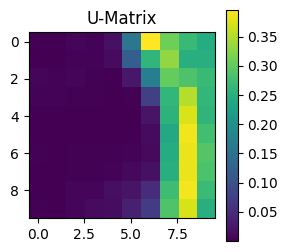

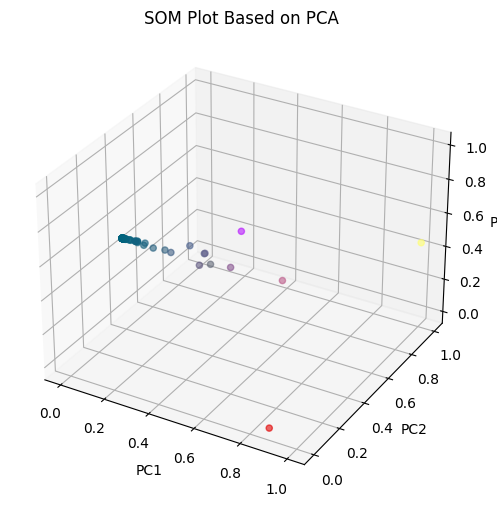

Epoch: 3, QE: 0.0665, TE: 0.23


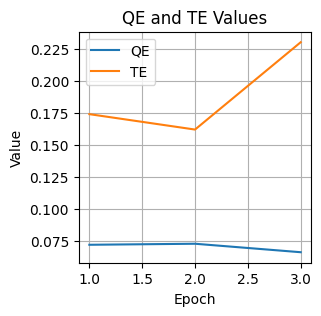

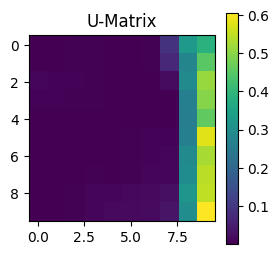

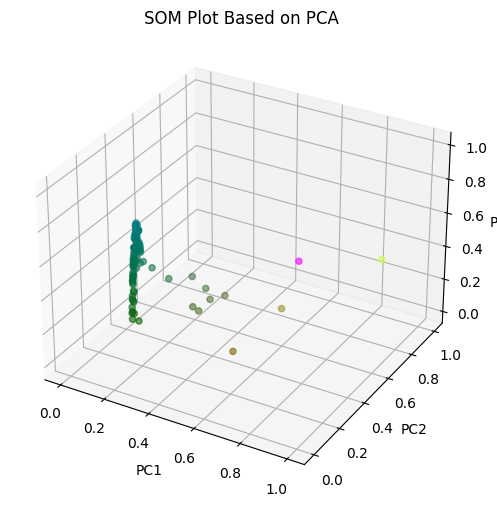

Epoch: 4, QE: 0.0666, TE: 0.226


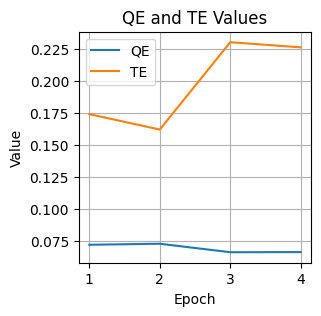

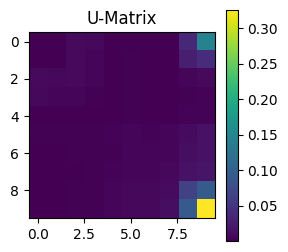

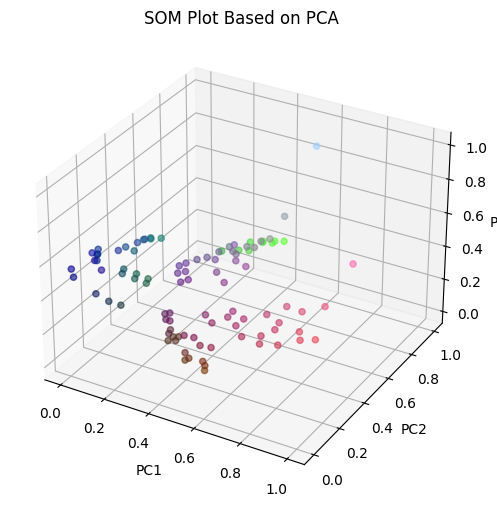

Epoch: 5, QE: 0.061, TE: 0.224


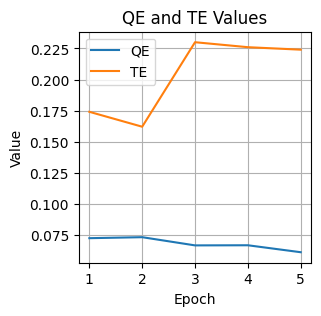

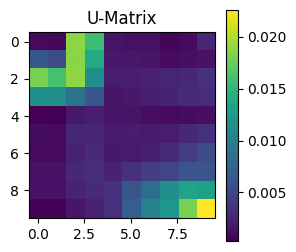

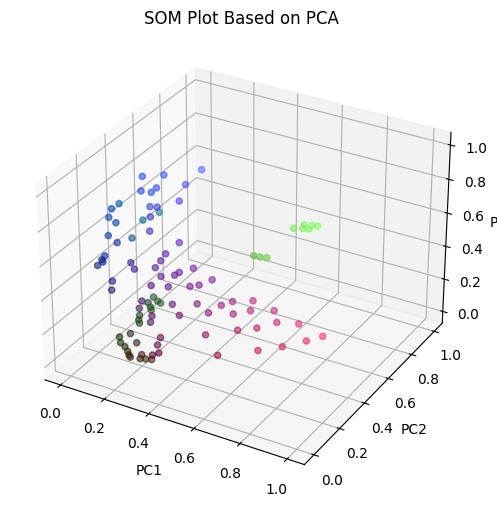

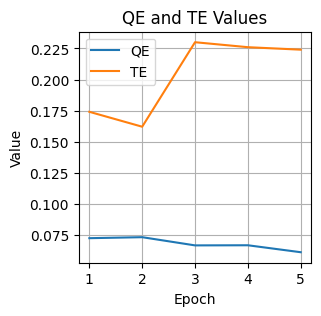

In [90]:
def plot_som_pca(SOM):
    # Reshape the SOM grid into a 2D array
    som_flat = SOM.reshape(-1, SOM.shape[-1])

    # Perform PCA with 3 components
    pca = PCA(n_components=3)
    som_pca = pca.fit_transform(som_flat)

    # Normalize PCA components to [0, 1]
    som_pca_norm = (som_pca - som_pca.min(axis=0)) / (som_pca.max(axis=0) - som_pca.min(axis=0))

    # Plot the SOM in 3D with PCA colors
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Assign PCA components to RGB channels
    colors = som_pca_norm

    # Plot each neuron's weight vector with PCA colors
    ax.scatter(som_pca_norm[:, 0], som_pca_norm[:, 1], som_pca_norm[:, 2], c=colors, alpha=0.6)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('SOM Plot Based on PCA')

    plt.show()

# Initialize SOM grid dimensions
m = 10
n = 10

# Initialize training data
train_data = sentence_vectors[:500]

# Initialize SOM grid with random weights
SOM = np.random.rand(m, n, train_data[0].shape[0])

epochs = 100
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(4, 4),
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
QE_values = []
TE_values = []
epoch_numbers = []

# Convert train_data to numpy array
train_data_array = np.array(train_data)

# Training loop
for epochs_per_iter, i in zip([5], range(1)):
    total_epochs += epochs_per_iter

    # Train the SOM for the specified number of epochs_per_iter
    for epoch in range(1, epochs_per_iter + 1):
        SOM = train_SOM(SOM, train_data_array, learn_rate=0.1, radius_sq=12, epochs=1)  # Train for 1 epoch

        # Calculate QE and TE
        QE = round(calculateQE(SOM, train_data_array), 4)
        TE = round(calculateTE(SOM, train_data_array), 4)

        # Print epoch number and QE, TE values
        print(f"Epoch: {total_epochs - epochs_per_iter + epoch}, QE: {QE}, TE: {TE}")

        # Save QE and TE values
        QE_values.append(QE)
        TE_values.append(TE)
        epoch_numbers.append(total_epochs - epochs_per_iter + epoch)

        # Save a copy of SOM at this epoch
        SOMS.append(SOM.copy())

        # Plot QE and TE values after each epoch
        plt.figure(figsize=(3, 3))
        plt.plot(epoch_numbers, QE_values, label='QE')
        plt.plot(epoch_numbers, TE_values, label='TE')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('QE and TE Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot the u_matrix after each epoch
        plt.figure(figsize=(3, 3))
        plt.imshow(u_matrix(SOM))
        plt.title('U-Matrix')
        plt.colorbar()
        plt.show()

        # Plot the SOM based on PCA
        plot_som_pca(SOM)

    # Plot the final state of the SOM grid after the last epoch
    if epoch == epochs_per_iter:
        plt.figure(figsize=(3, 3))
        plt.plot(epoch_numbers, QE_values, label='QE')
        plt.plot(epoch_numbers, TE_values, label='TE')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('QE and TE Values')
        plt.legend()
        plt.grid(True)
        plt.show()

    ax.imshow(u_matrix(SOM))
    ax.title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

# Show the final plot
plt.show()

Epoch: 1, QE: 0.0545, TE: 0.2023


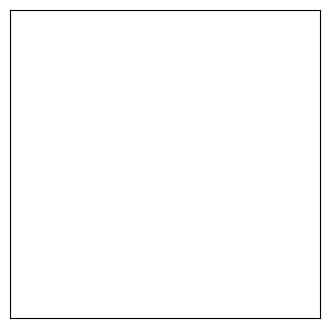

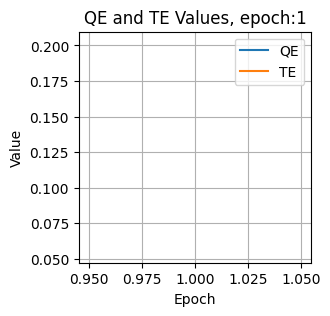

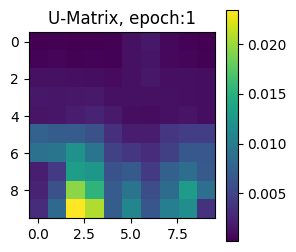

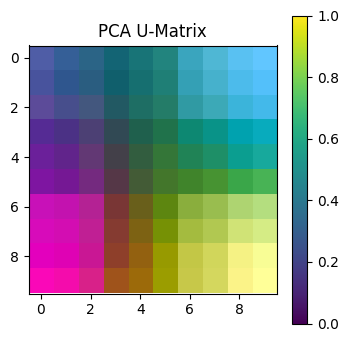

Epoch: 2, QE: 0.0465, TE: 0.2006


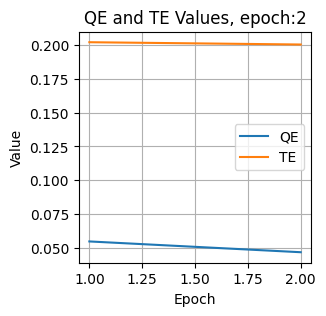

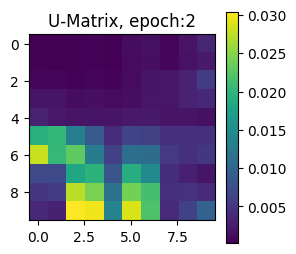

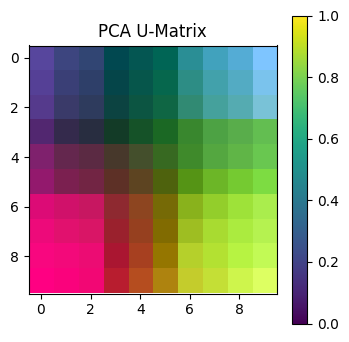

Epoch: 3, QE: 0.047, TE: 0.1558


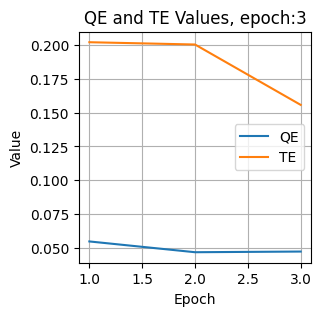

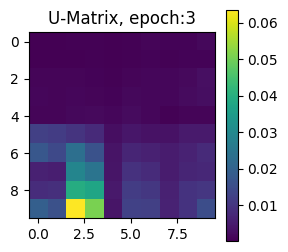

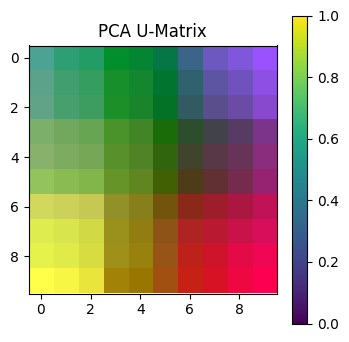

Epoch: 4, QE: 0.0528, TE: 0.1871


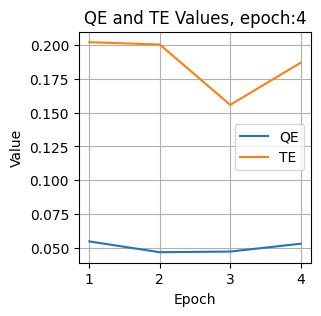

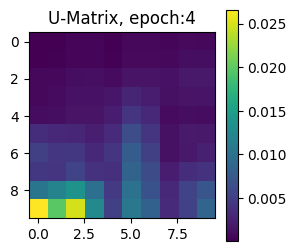

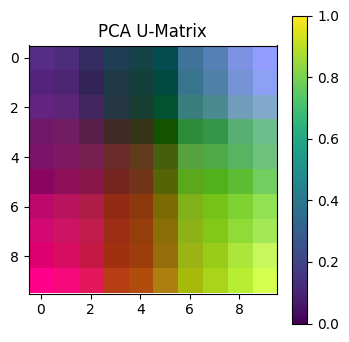

Epoch: 5, QE: 0.0472, TE: 0.13


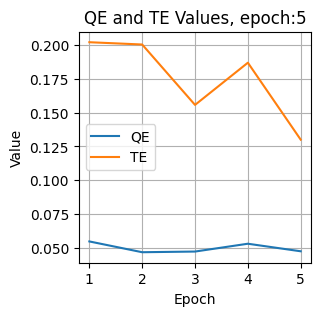

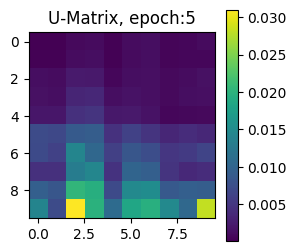

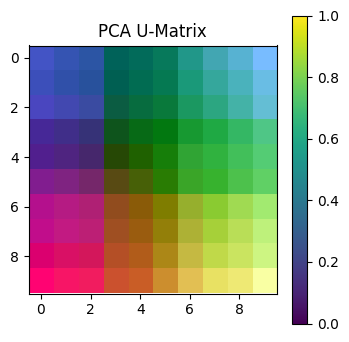

Epoch: 6, QE: 0.0597, TE: 0.165


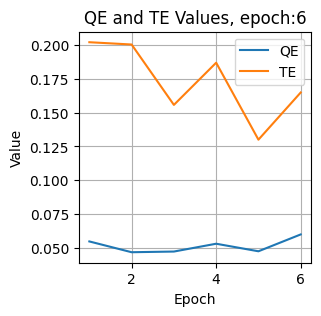

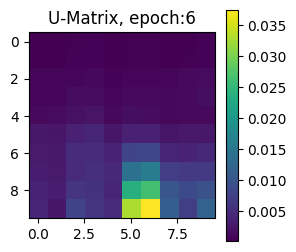

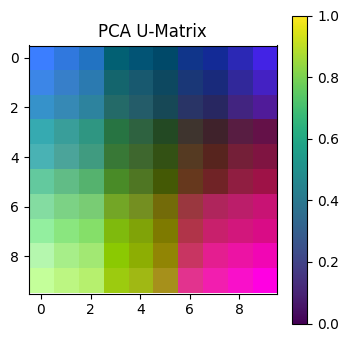

Epoch: 7, QE: 0.0549, TE: 0.1249


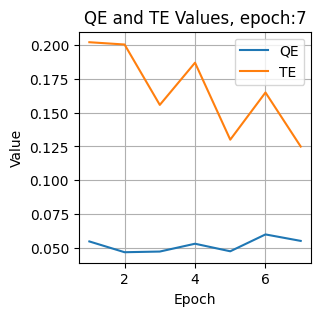

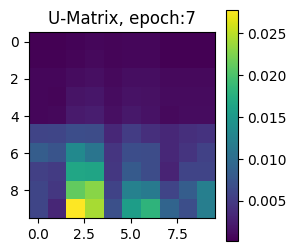

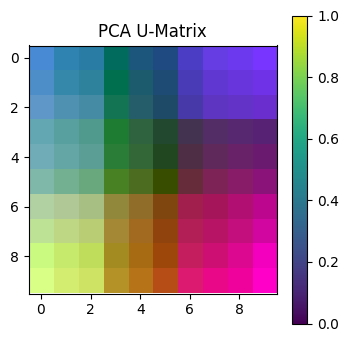

Epoch: 8, QE: 0.0487, TE: 0.1595


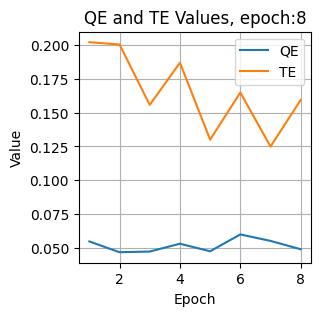

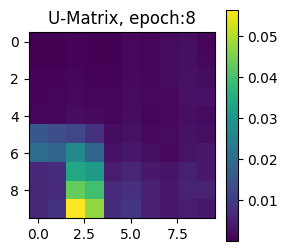

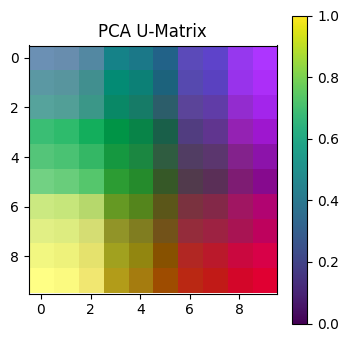

Epoch: 9, QE: 0.0492, TE: 0.1739


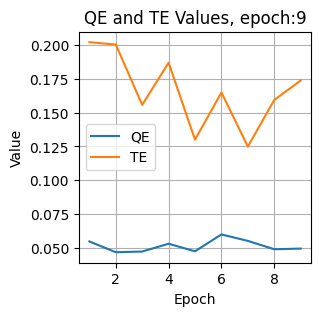

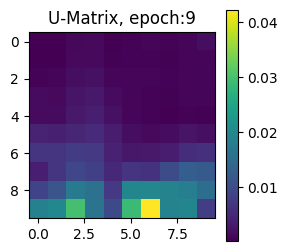

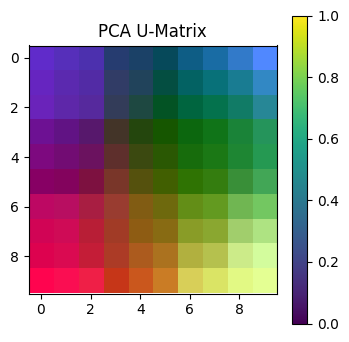

Epoch: 10, QE: 0.049, TE: 0.1536


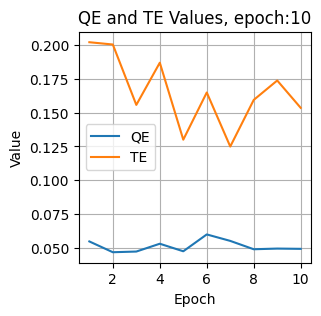

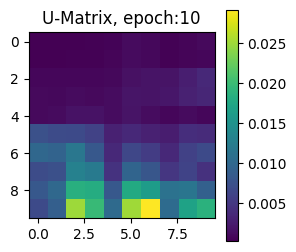

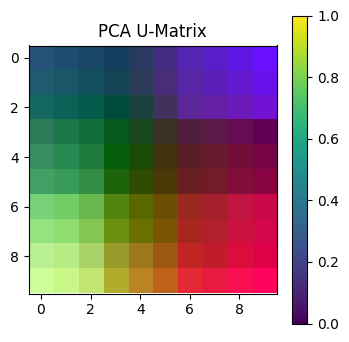

Epoch: 11, QE: 0.055, TE: 0.1297


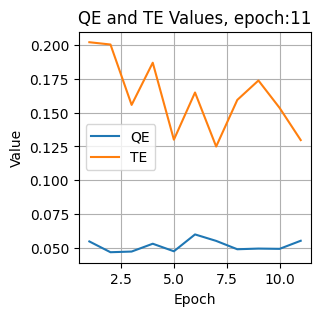

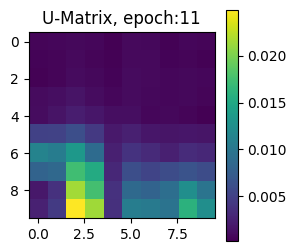

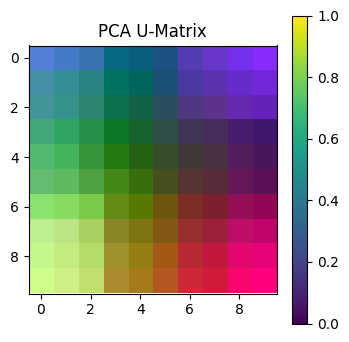

Epoch: 12, QE: 0.0484, TE: 0.1492


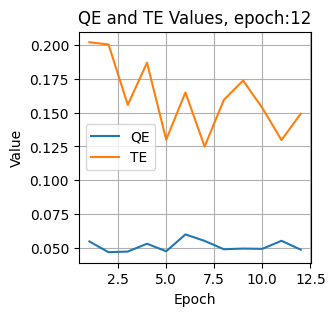

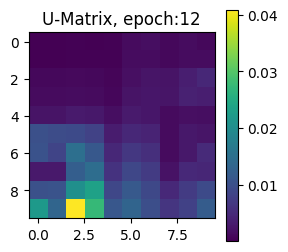

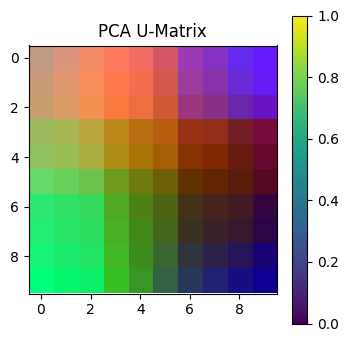

Epoch: 13, QE: 0.0476, TE: 0.156


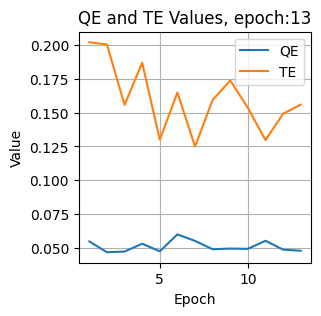

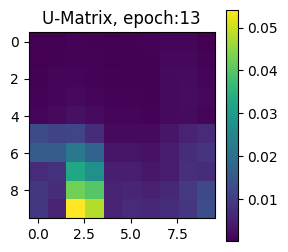

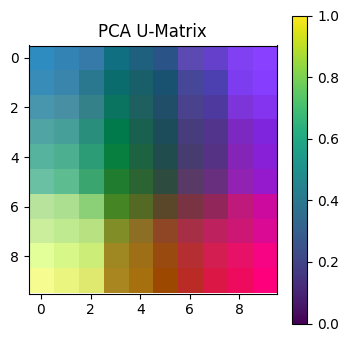

Epoch: 14, QE: 0.0535, TE: 0.1196


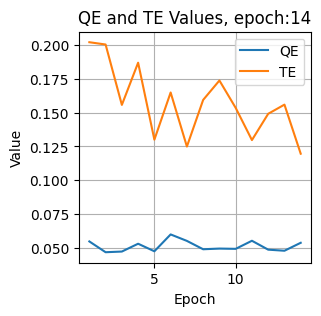

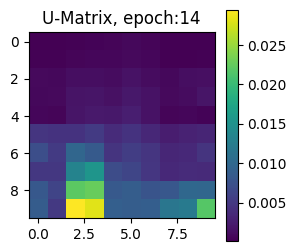

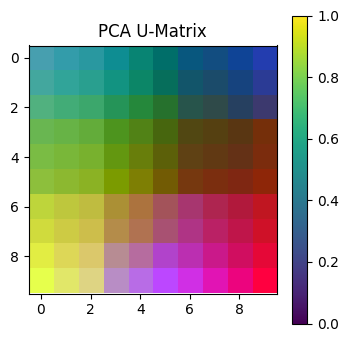

Epoch: 15, QE: 0.0501, TE: 0.1516


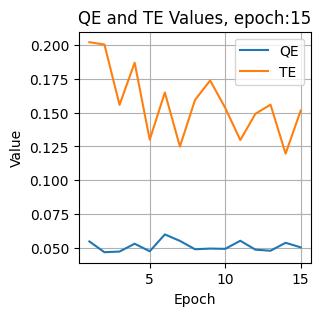

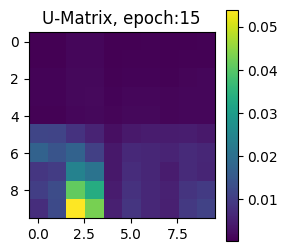

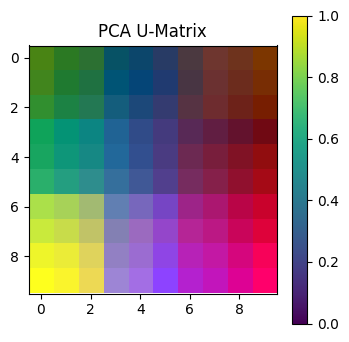

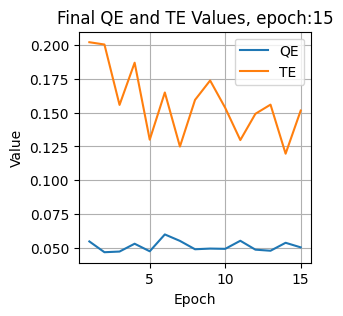

In [92]:
def plot_som_pca(SOM):
    # Reshape the SOM grid into a 2D array
    som_flat = SOM.reshape(-1, SOM.shape[-1])

    # Perform PCA with 3 components
    pca = PCA(n_components=3)
    som_pca = pca.fit_transform(som_flat)

    # Normalize PCA components to [0, 1]
    som_pca_norm = (som_pca - som_pca.min(axis=0)) / (som_pca.max(axis=0) - som_pca.min(axis=0))

    # Create a U-matrix with PCA components as RGB values
    u_matrix_pca = som_pca_norm.reshape(SOM.shape[:-1] + (3,))

    # Plot the U-matrix with PCA colors
    plt.figure(figsize=(4, 4))
    plt.imshow(u_matrix_pca)
    plt.title('PCA U-Matrix')
    plt.colorbar()
    plt.show()

# Initialize SOM grid dimensions
m = 10
n = 10

# Initialize training data
train_data = sentence_vectors

# Initialize SOM grid with random weights
SOM = np.random.rand(m, n, train_data[0].shape[0])

epochs = 100
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(4, 4),
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
QE_values = []
TE_values = []
epoch_numbers = []

# Convert train_data to numpy array
train_data_array = np.array(train_data)

# Training loop
for epochs_per_iter, i in zip([15], range(1)):
    total_epochs += epochs_per_iter

    # Train the SOM for the specified number of epochs_per_iter
    for epoch in range(1, epochs_per_iter + 1):
        SOM = train_SOM(SOM, train_data_array, learn_rate=0.1, radius_sq=12, epochs=1)  # Train for 1 epoch

        # Calculate QE and TE
        QE = round(calculateQE(SOM, train_data_array), 4)
        TE = round(calculateTE(SOM, train_data_array), 4)

        # Print epoch number and QE, TE values
        print(f"Epoch: {total_epochs - epochs_per_iter + epoch}, QE: {QE}, TE: {TE}")

        # Save QE and TE values
        QE_values.append(QE)
        TE_values.append(TE)
        epoch_numbers.append(total_epochs - epochs_per_iter + epoch)

        # Save a copy of SOM at this epoch
        SOMS.append(SOM.copy())

        # Plot QE and TE values after each epoch
        plt.figure(figsize=(3, 3))
        plt.plot(epoch_numbers, QE_values, label='QE')
        plt.plot(epoch_numbers, TE_values, label='TE')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('QE and TE Values, epoch:'+str(epoch))
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot the u_matrix after each epoch
        plt.figure(figsize=(3, 3))
        plt.imshow(u_matrix(SOM))
        plt.title('U-Matrix, epoch:'+str(epoch))
        plt.colorbar()
        plt.show()

        # Plot the SOM based on PCA
        plot_som_pca(SOM)

    # Plot the final state of the SOM grid after the last epoch
    if epoch == epochs_per_iter:
        plt.figure(figsize=(3, 3))
        plt.plot(epoch_numbers, QE_values, label='QE')
        plt.plot(epoch_numbers, TE_values, label='TE')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Final QE and TE Values, epoch:'+str(epoch))
        plt.legend()
        plt.grid(True)
        plt.show()

    ax.imshow(u_matrix(SOM))
    ax.title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

# Show the final plot
plt.show()

### Epoch 12 is chosen because the QE & TE is closest to 0

In [94]:
SOM= SOMS[11]

In [95]:
QE = QE_values[11]
TE = TE_values[11]

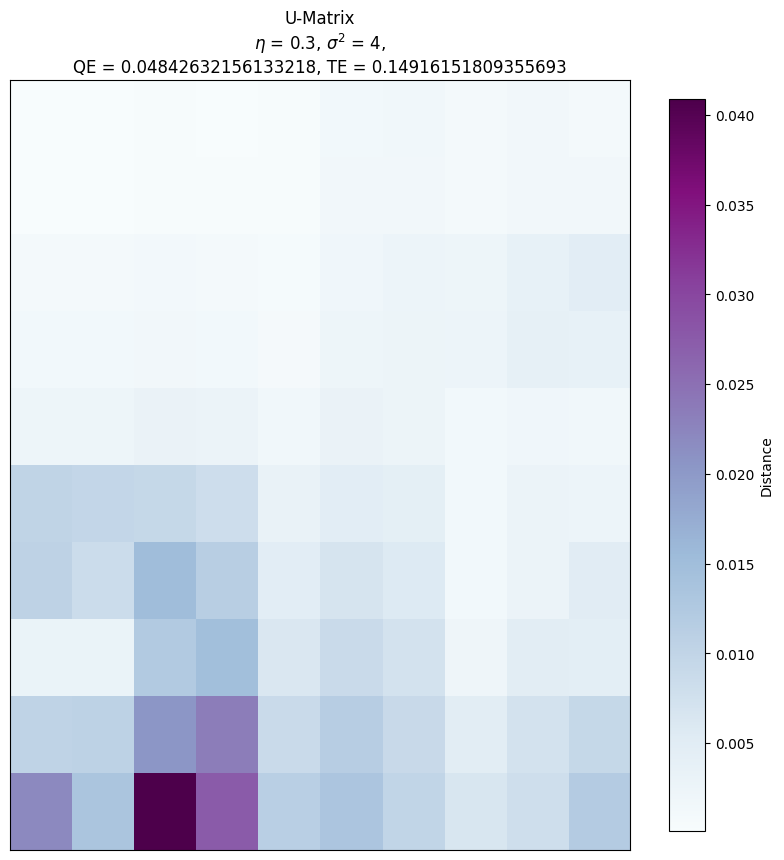

In [97]:
u_matrix_values = u_matrix(SOM)

plt.figure(figsize=(10, 10))
im = plt.imshow(u_matrix_values, cmap=cm.BuPu, aspect='auto')
plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4},\nQE = {QE}, TE = {TE}')
plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()

In [98]:
som_model = SOMS[11]

In [108]:
with open('som_model.pkl', 'wb') as f:
    pickle.dump(som_model, f)

In [109]:
with open('som_model.pkl', 'rb') as f:
    loaded_text_som_model = pickle.load(f)

In [107]:
data_dict = []
for i in range(len(loaded_text_som_model)):
    row = []
    for j in range(len(loaded_text_som_model[0])):
        row.append([])
    data_dict.append(row)
vectortextPairs=[]
for i in range(0,len(paragraphs)):
    vectortext={}
    vectortext['text']=paragraphs[i]
    vectortext['vector']=sentence_vectors[i]
    vectortextPairs.append(vectortext)
for i in vectortextPairs:
    g,h = find_BMU1(loaded_text_som_model,i['vector'])
    data_dict[g][h].append(i)

### Defining search function

In [110]:
def searchtextsom(query):
    result = []
    query = [query]
    preprocessed_query = preprocess(query)
    query_vector = model1.infer_vector(preprocessed_query[0].split())
    activatedSOM = activate1(sentence_vectors, loaded_text_som_model, query_vector)
    fig = plt.figure()
    plt.figure(figsize=(10, 10))
    im = plt.imshow(activatedSOM, cmap=cm.BuPu, aspect='auto')
    plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4},\nQE = {QE}, TE = {TE}')
    plt.colorbar(im, shrink=0.95, label='Distance')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    g, h = find_BMU1(loaded_text_som_model, query_vector)
    print((g, h))
    similarities = {}
    for i in data_dict[g][h]:
        vector_array = np.array([i['vector']])
        vector_array = vector_array.reshape(1, -1) 
        similarities[i['text']] = cosine_similarity(vector_array, [loaded_text_som_model[g][h]])
    biggest = None
    max_similarity = similarities[data_dict[g][h][0]['text']]
    for i in data_dict[g][h]:
        sim = similarities[i['text']]
        if sim > max_similarity:
            max_similarity = sim
            biggest = i['text']
    result.append(biggest)
    return result

<Figure size 640x480 with 0 Axes>

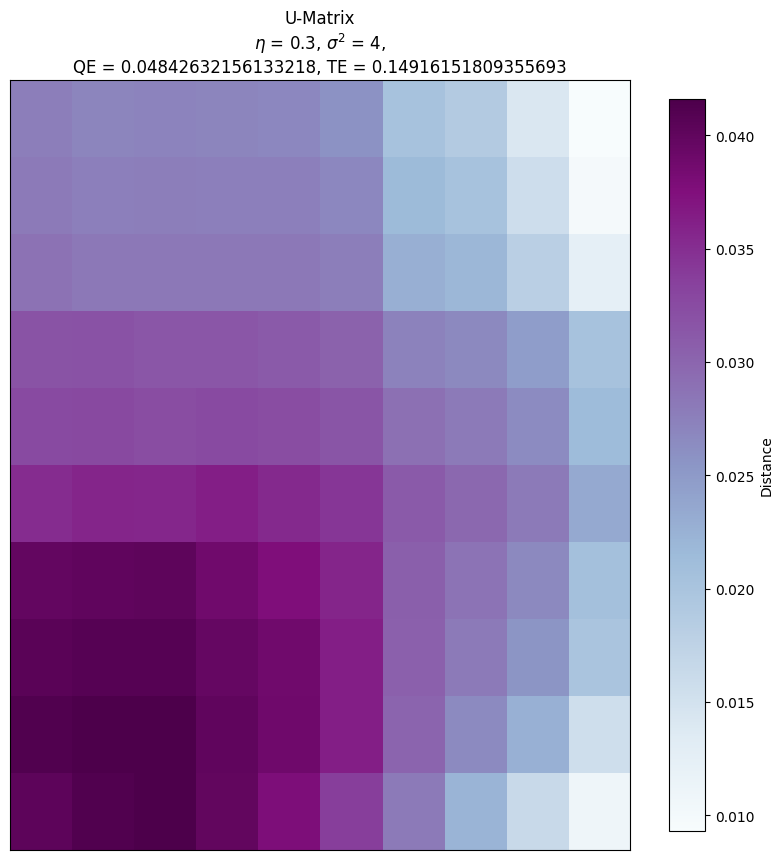

(3, 3)


[' One could assume that Withers and his associates were now in disgrace, but there had been no report of the matter in the Press or on the telescreen. That was to be expected, since it was unusual for political offenders to be put on trial or even publicly denounced.']

In [114]:
searchtextsom('A parliament of counter-culture.')

## TF-IDF Alternative

In [140]:
vectorizer = TfidfVectorizer()
TFidf_vectors = vectorizer.fit_transform(processed_text)

In [141]:
svd = TruncatedSVD(n_components=300)
svd_u_matrix = svd.fit_transform(TFidf_vectors)

In [142]:
with open('svd_u_matrix.pkl', 'wb') as f:
    pickle.dump(svd_u_matrix, f)

In [143]:
with open('svd_u_matrix.pkl', 'rb') as f:
    svd_u_matrix = pickle.load(f)

Epoch: 1, QE: 0.7542, TE: 0.2354


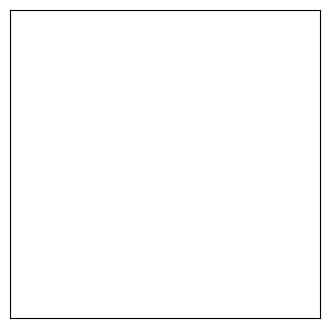

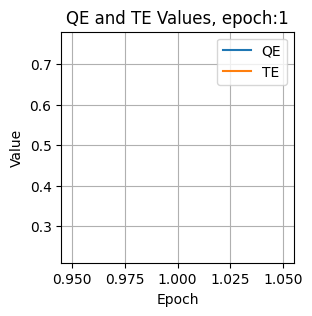

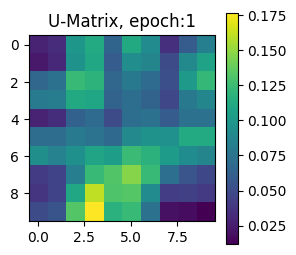

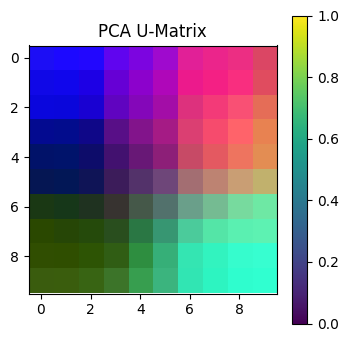

Epoch: 2, QE: 0.7613, TE: 0.252


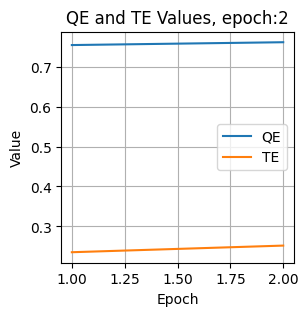

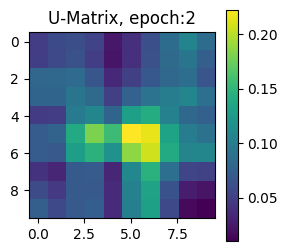

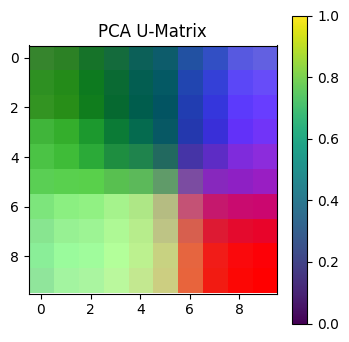

Epoch: 3, QE: 0.7598, TE: 0.235


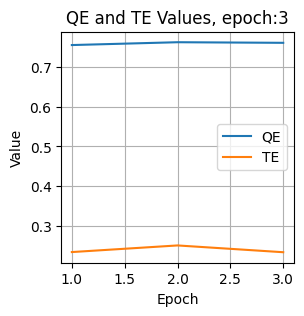

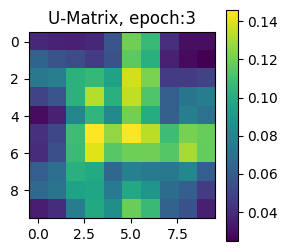

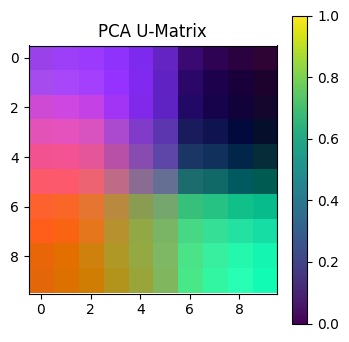

Epoch: 4, QE: 0.7629, TE: 0.2809


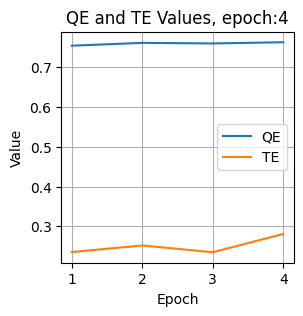

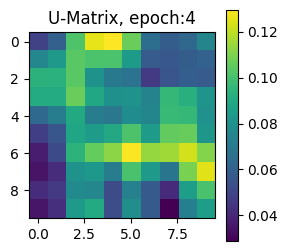

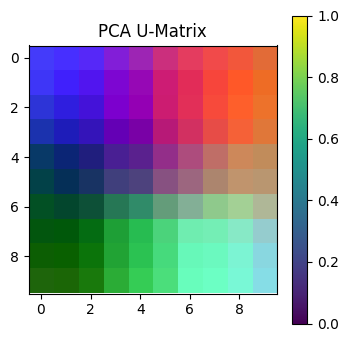

Epoch: 5, QE: 0.763, TE: 0.233


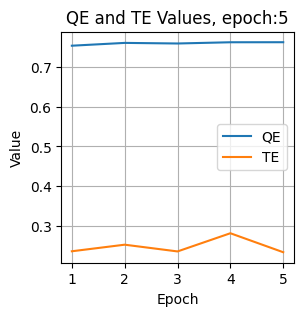

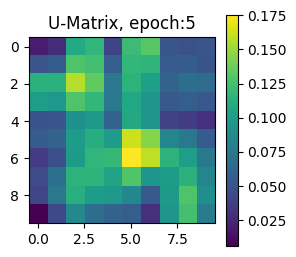

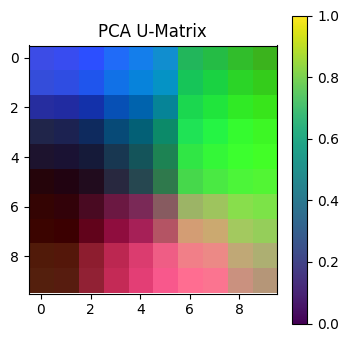

Epoch: 6, QE: 0.763, TE: 0.2458


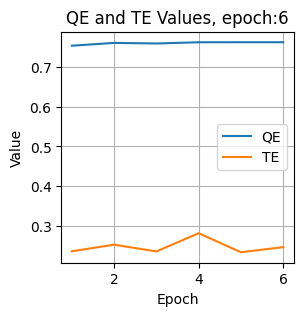

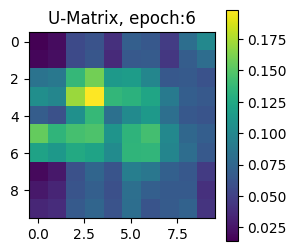

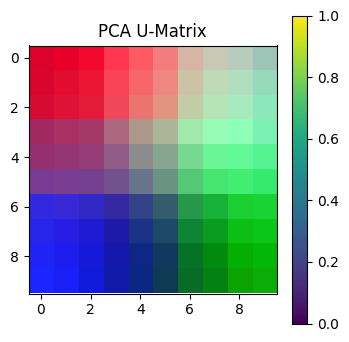

Epoch: 7, QE: 0.7655, TE: 0.2251


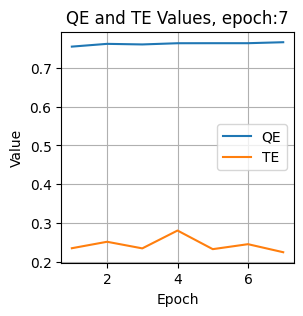

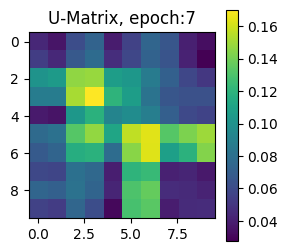

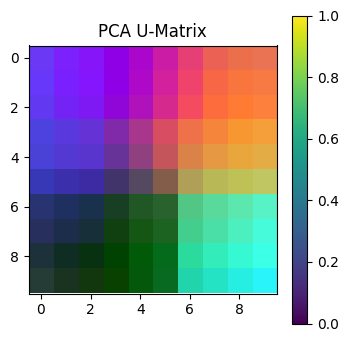

Epoch: 8, QE: 0.7605, TE: 0.2685


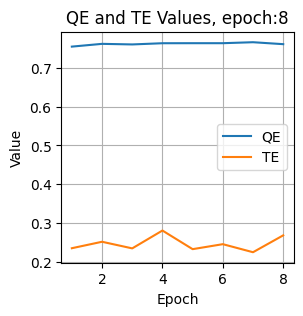

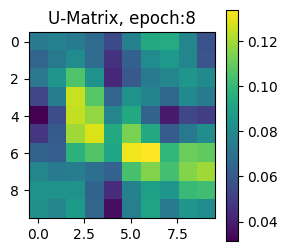

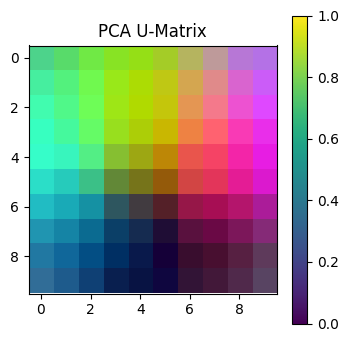

Epoch: 9, QE: 0.7597, TE: 0.2513


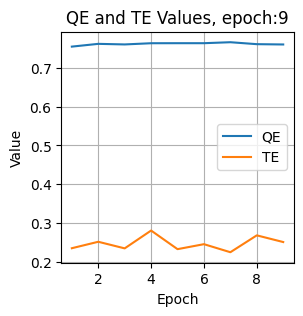

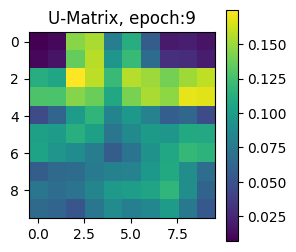

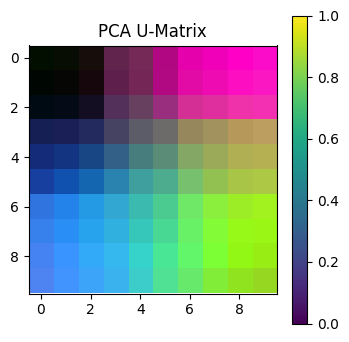

Epoch: 10, QE: 0.7605, TE: 0.2339


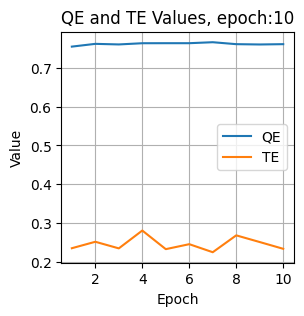

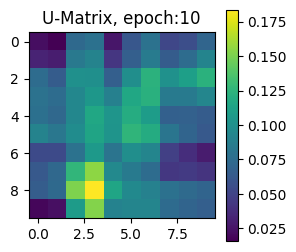

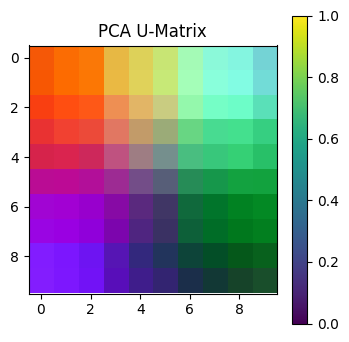

Epoch: 11, QE: 0.7611, TE: 0.2412


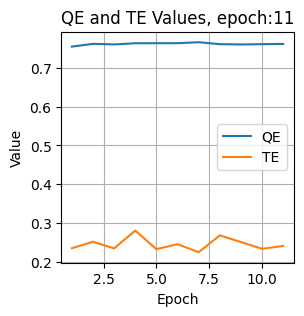

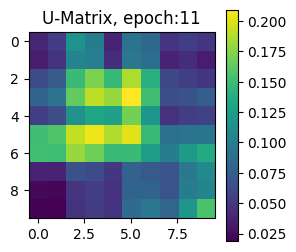

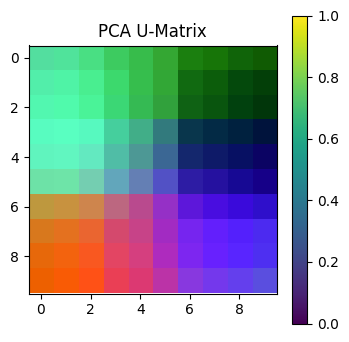

Epoch: 12, QE: 0.7616, TE: 0.2429


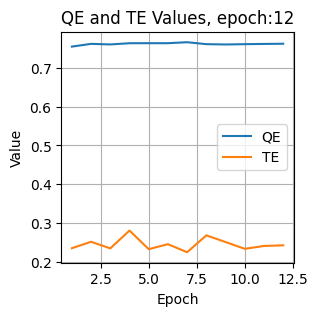

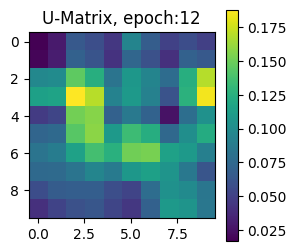

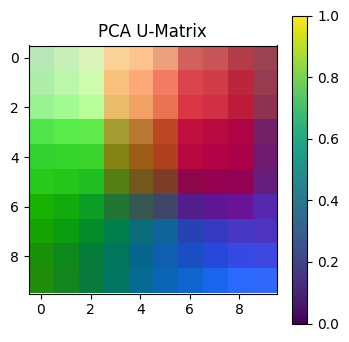

Epoch: 13, QE: 0.7575, TE: 0.2418


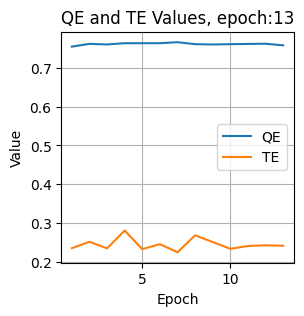

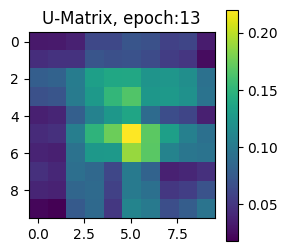

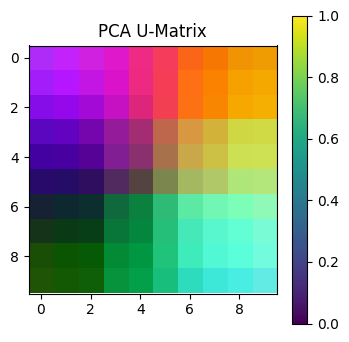

Epoch: 14, QE: 0.7659, TE: 0.2688


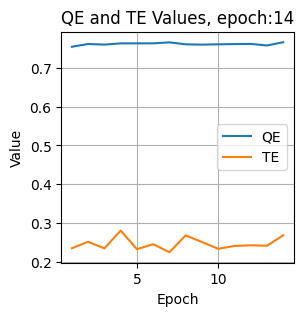

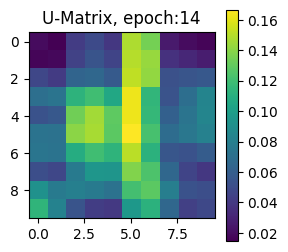

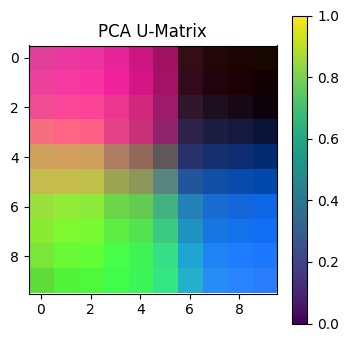

Epoch: 15, QE: 0.7609, TE: 0.2522


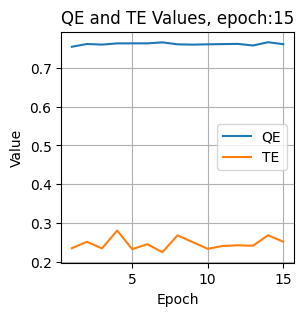

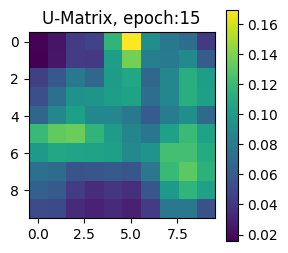

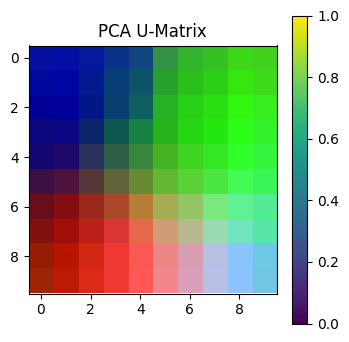

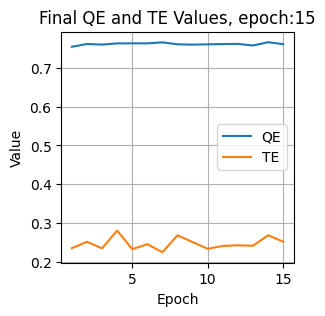

In [144]:
def plot_som_pca(SOM):
    # Reshape the SOM grid into a 2D array
    som_flat = SOM.reshape(-1, SOM.shape[-1])

    # Perform PCA with 3 components
    pca = PCA(n_components=3)
    som_pca = pca.fit_transform(som_flat)

    # Normalize PCA components to [0, 1]
    som_pca_norm = (som_pca - som_pca.min(axis=0)) / (som_pca.max(axis=0) - som_pca.min(axis=0))

    # Create a U-matrix with PCA components as RGB values
    u_matrix_pca = som_pca_norm.reshape(SOM.shape[:-1] + (3,))

    # Plot the U-matrix with PCA colors
    plt.figure(figsize=(4, 4))
    plt.imshow(u_matrix_pca)
    plt.title('PCA U-Matrix')
    plt.colorbar()
    plt.show()

# Initialize SOM grid dimensions
m = 10
n = 10

# Initialize training data
train_data = svd_u_matrix

# Initialize SOM grid with random weights
SOM = np.random.rand(m, n, train_data[0].shape[0])

epochs = 100
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(4, 4),
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
QE_values = []
TE_values = []
epoch_numbers = []

# Convert train_data to numpy array
train_data_array = np.array(train_data)

# Training loop
for epochs_per_iter, i in zip([15], range(1)):
    total_epochs += epochs_per_iter

    # Train the SOM for the specified number of epochs_per_iter
    for epoch in range(1, epochs_per_iter + 1):
        SOM = train_SOM(SOM, train_data_array, learn_rate=0.1, radius_sq=12, epochs=1)  # Train for 1 epoch

        # Calculate QE and TE
        QE = round(calculateQE(SOM, train_data_array), 4)
        TE = round(calculateTE(SOM, train_data_array), 4)

        # Print epoch number and QE, TE values
        print(f"Epoch: {total_epochs - epochs_per_iter + epoch}, QE: {QE}, TE: {TE}")

        # Save QE and TE values
        QE_values.append(QE)
        TE_values.append(TE)
        epoch_numbers.append(total_epochs - epochs_per_iter + epoch)

        # Save a copy of SOM at this epoch
        SOMS.append(SOM.copy())

        # Plot QE and TE values after each epoch
        plt.figure(figsize=(3, 3))
        plt.plot(epoch_numbers, QE_values, label='QE')
        plt.plot(epoch_numbers, TE_values, label='TE')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('QE and TE Values, epoch:'+str(epoch))
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot the u_matrix after each epoch
        plt.figure(figsize=(3, 3))
        plt.imshow(u_matrix(SOM))
        plt.title('U-Matrix, epoch:'+str(epoch))
        plt.colorbar()
        plt.show()

        # Plot the SOM based on PCA
        plot_som_pca(SOM)

    # Plot the final state of the SOM grid after the last epoch
    if epoch == epochs_per_iter:
        plt.figure(figsize=(3, 3))
        plt.plot(epoch_numbers, QE_values, label='QE')
        plt.plot(epoch_numbers, TE_values, label='TE')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Final QE and TE Values, epoch:'+str(epoch))
        plt.legend()
        plt.grid(True)
        plt.show()

    ax.imshow(u_matrix(SOM))
    ax.title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

# Show the final plot
plt.show()

In [ ]:
SOM= SOMS[9]

In [145]:
with open('text_tfidf_model.pkl', 'wb') as f:
    pickle.dump(SOM, f)

In [146]:
with open('text_tfidf_model.pkl', 'rb') as f:
    TFidf_loaded_som_model = pickle.load(f)

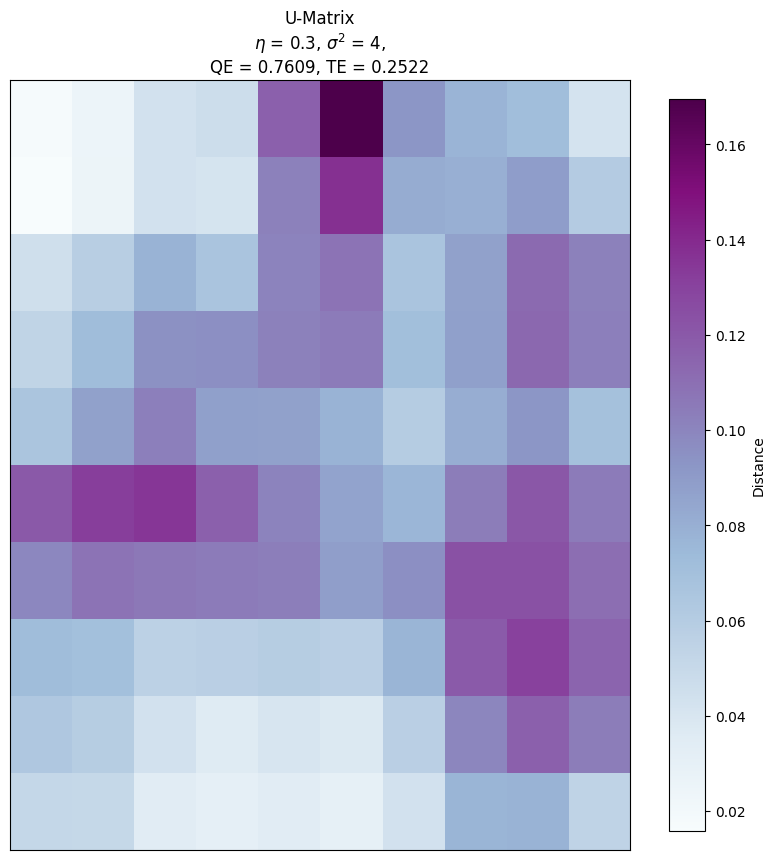

In [148]:
u_matrix_values = u_matrix(TFidf_loaded_som_model)
QE = round(calculateQE(TFidf_loaded_som_model, svd_u_matrix), 4)
TE = round(calculateTE(TFidf_loaded_som_model, svd_u_matrix), 4)

plt.figure(figsize=(10, 10))
im = plt.imshow(u_matrix_values, cmap=cm.BuPu, aspect='auto')
plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4},\nQE = {QE}, TE = {TE}')
plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()

In [149]:
Tfidf_data_dict = []
for i in range(len(TFidf_loaded_som_model)):
    row = []
    for j in range(len(TFidf_loaded_som_model[0])):
        row.append([])
    Tfidf_data_dict.append(row)
vectorTFidftextPairs=[]
for i in range(0,len(paragraphs)):
    vectorTFidftext={}
    vectorTFidftext['text']=paragraphs[i]
    vectorTFidftext['vector']=svd_u_matrix[i]
    vectorTFidftextPairs.append(vectorTFidftext)
for i in vectortextPairs:
    g,h = find_BMU1(TFidf_loaded_som_model,i['vector'])
    Tfidf_data_dict[g][h].append(i)

## Fit PCA on All Cells

In [150]:
som_height, som_width, vector_dimension = loaded_text_som_model.shape
num_nodes = som_height * som_width

flattened_som = loaded_text_som_model.reshape(num_nodes, vector_dimension)

pca = PCA(n_components=3)
colourComponents = pca.fit_transform(flattened_som)

In [151]:
colourComponents=normalise(colourComponents,colourComponents)

rgb_values = (colourComponents * 255).astype(int)

som_colors = np.zeros((som_height, som_width, 3), dtype=np.uint8)

for i in range(som_height):
    for j in range(som_width):
        node_idx = i * som_width + j
        som_colors[i, j] = rgb_values[node_idx]

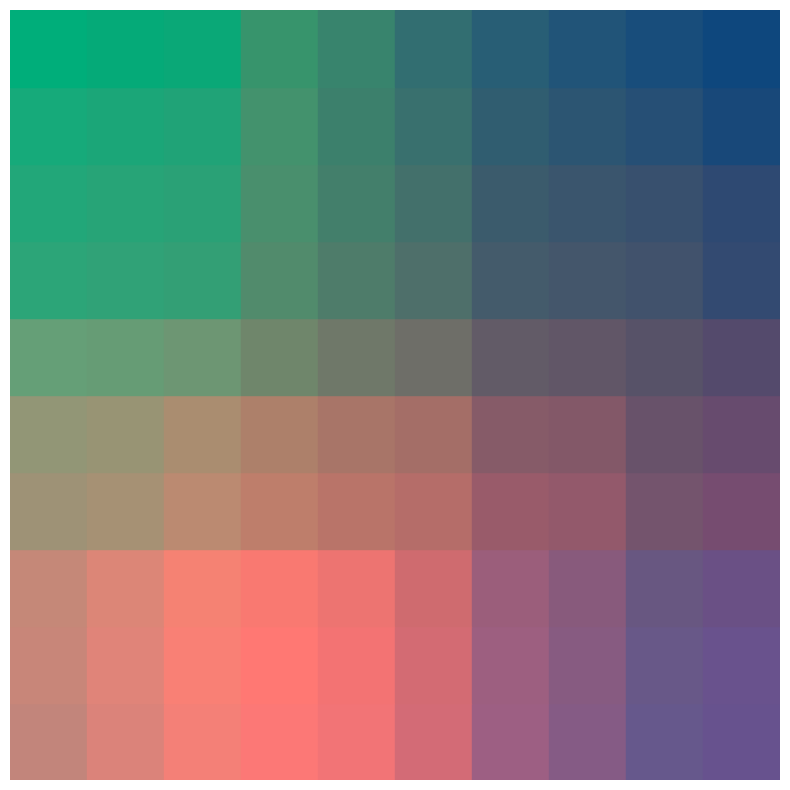

In [152]:
fig, ax = plt.subplots(figsize=(som_width, som_height))

for i in range(som_height):
    for j in range(som_width):
        color = som_colors[i, j] / 255.0
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

ax.set_xlim(0, som_width)
ax.set_ylim(0, som_height)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

### Fit PCA on Entire Training

In [153]:
pca = PCA(n_components=3)
colourComponents = pca.fit_transform(sentence_vectors)

In [154]:
som_height, som_width, vector_dimension = loaded_text_som_model.shape
num_nodes = som_height * som_width

flattened_som = loaded_text_som_model.reshape(num_nodes, vector_dimension)

In [155]:
colourComponents = pca.transform(flattened_som)

In [156]:
colourComponents=normalise(colourComponents,colourComponents)

rgb_values = (colourComponents * 255).astype(int)

som_colors = np.zeros((som_height, som_width, 3), dtype=np.uint8)

for i in range(som_height):
    for j in range(som_width):
        node_idx = i * som_width + j
        som_colors[i, j] = rgb_values[node_idx]

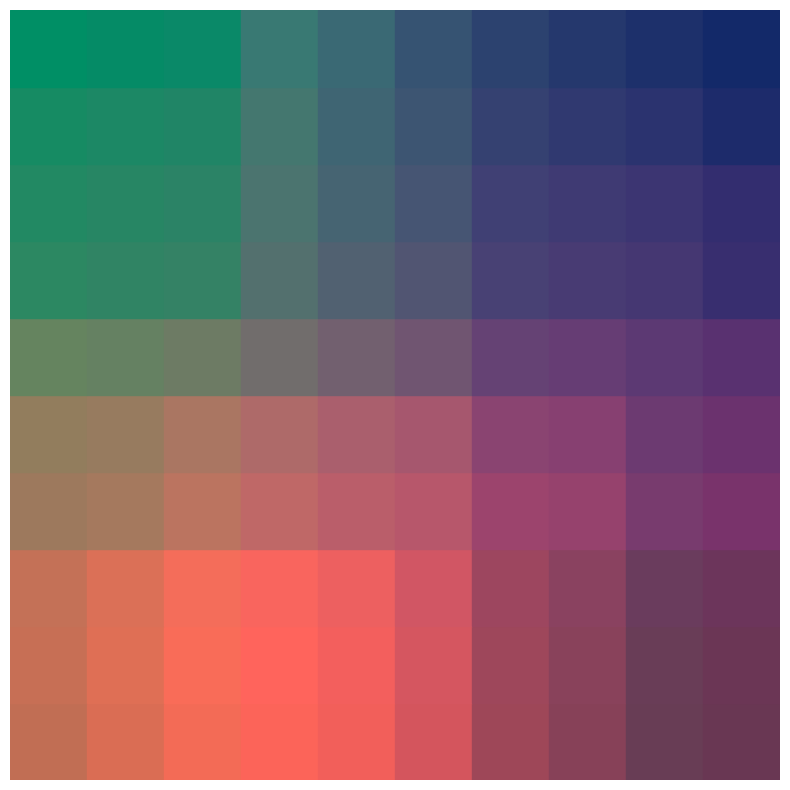

In [157]:
fig, ax = plt.subplots(figsize=(som_width, som_height))

for i in range(som_height):
    for j in range(som_width):
        color = som_colors[i, j] / 255.0
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

ax.set_xlim(0, som_width)
ax.set_ylim(0, som_height)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

In [158]:
def searchTFidftextsom(query):
    result=[]
    query=[query]
    preprocessed_query=preprocess(query)
    vectorizer = TfidfVectorizer()
    TFidf_vectors = vectorizer.fit_transform(processed_text)
    query_vector = vectorizer.transform(preprocessed_query)
    svd = TruncatedSVD(n_components=300)
    svd_u_matrix = svd.fit_transform(TFidf_vectors)
    svd_query_u_matrix = svd.transform(query_vector).flatten()
    unit = find_BMU1(TFidf_loaded_som_model, svd_query_u_matrix)
    print(unit)
    activatedSOM = activate1(svd_u_matrix, TFidf_loaded_som_model, svd_query_u_matrix)
    fig = plt.figure()
    plt.figure(figsize=(10, 10))
    im = plt.imshow(activatedSOM, cmap=cm.BuPu, aspect='auto')
    plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4},\nQE = {QE}, TE = {TE}')
    plt.colorbar(im, shrink=0.95, label='Distance')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    similarities = {}
    for i in Tfidf_data_dict[g][h]:
        vector_array = np.array([i['vector']])
        vector_array = vector_array.reshape(1, -1) 
        similarities[i['text']] = cosine_similarity(vector_array, [TFidf_loaded_som_model[g][h]])
    biggest = None
    max_similarity = similarities[Tfidf_data_dict[g][h][0]['text']]
    for i in Tfidf_data_dict[g][h]:
        sim = similarities[i['text']]
        if sim > max_similarity:
            max_similarity = sim
            biggest = i['text']
    result.append(biggest)
    return result

(9, 0)


<Figure size 640x480 with 0 Axes>

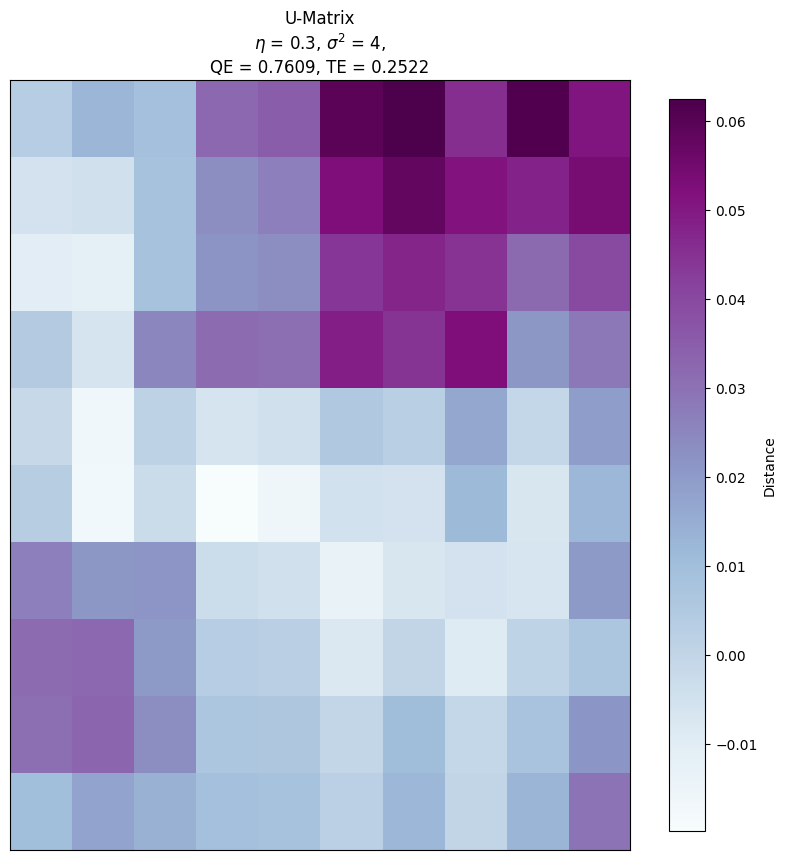

[' The steel door opened with a clang. A young officer, a trim black–uniformed figure who seemed to glitter all over with polished leather, and whose pale, straight–featured face was like a wax mask, stepped smartly through the doorway.']

In [159]:
searchTFidftextsom('A parliament of counter-culture.')